In [ ]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

In [57]:
data = torch.load("tensors3.pt")
# data[100, :, :, 0].shape

In [69]:
features_list = []
labels_list = []

for i in range(data.shape[0]):
    feature_map = data[i, :, :, 1:].permute(2, 0, 1)
    labels = data[i, :, :, 0]
    label = labels.mean()
    features_list.append(feature_map)
    labels_list.append(label)

In [70]:
import numpy as np

q25 = np.quantile(labels_list, 0.25)
q50 = np.quantile(labels_list, 0.5)
q75 = np.quantile(labels_list, 0.75)

print("25th percentile:", q25)
print("50th percentile:", q50)
print("75th percentile:", q75)

def quantize(value):
    if value <= q25:
        return 0
    elif value <= q50:
        return 1
    elif value <= q75:
        return 2
    else:
        return 3


quantized_labels = [quantize(x) for x in labels_list]

25th percentile: 43.14
50th percentile: 50.984
75th percentile: 55.599999999999994


In [71]:
def create_dataset(features_list = features_list, labels_list = quantized_labels):
    labels = torch.tensor(labels_list)
    features = torch.stack(features_list)
    dataset = TensorDataset(features, labels)
    return dataset


def train_val_test_split(dataset, val_indices, test_indices):
    all_indices = set(range(len(dataset)))
    train_indices = list(all_indices - set(val_indices) - set(test_indices))
    train_indices.sort()
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, val_dataset, test_dataset


dataset = create_dataset()
val_indices = [20, 33, 52, 71, 90, 110, 132, 155, 177, 197, 219, 237, 250, 257, 22, 39, 58, 77, 96, 116, 138, 161, 183, 203, 225, 243]
test_indices = [21, 34, 53, 72, 91, 111, 133, 154, 178, 198, 220, 238, 251, 258, 23, 40, 59, 78, 97, 117, 139, 162, 184, 204, 226, 244]
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset, val_indices, test_indices)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 519
Validation dataset size: 26
Test dataset size: 26


(array([ 32.,  12.,  17.,  12.,  15.,  17.,  72., 145., 188.,  61.]),
 array([ 0.688 ,  7.1488, 13.6096, 20.0704, 26.5312, 32.992 , 39.4528,
        45.9136, 52.3744, 58.8352, 65.296 ]),
 <BarContainer object of 10 artists>)

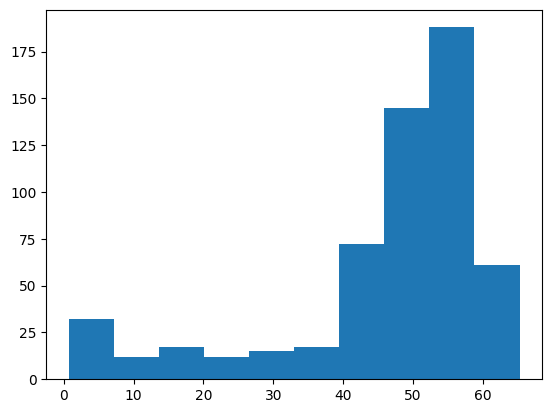

In [72]:
import matplotlib.pyplot as plt
plt.hist(labels_list, bins=10)

In [73]:
features_list[0].shape
labels_list[0]

tensor(23.3200, dtype=torch.float64)

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 12, 12)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 6, 6)
        # x = self.pool(F.relu(self.conv3(x)))  # (64, 3, 3)
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [82]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def _train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc = "Training", leave = False):
        inputs, labels = inputs.float().to(device), labels.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim = 1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    return total_loss / len(dataloader), accuracy



def _validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc = "Validation", leave = False):
            inputs, labels = inputs.float().to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim = 1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    
    return total_loss / len(dataloader), accuracy




def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, patience = np.inf):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_acc = 0
    best_epoch = 0
    max_epoch = 0
    is_quit = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = _train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = _validate(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        max_epoch += 1
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            is_quit = 0
        else:
            is_quit += 1
            
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f},\
                    Train Accuracy: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f},\
                    Val Accuracy: {val_acc:.4f}")
            print("-" * 50)
        
        if is_quit > patience:
            break
    print(f"BEST EPOCH: {best_epoch:.2f}\
          BEST ACCURACY: {val_accs[best_epoch]:.2f}")
    
    return [*range(1, max_epoch + 1)], train_losses, val_losses, train_accs, val_accs, best_epoch

In [83]:
model = CNNClassifier(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs, train_losses, val_losses, train_accs, val_accs, best_epoch = train_model(model, criterion, optimizer, 100, train_loader, val_loader, "cpu")

ValueError: Expected input batch_size (128) to match target batch_size (32).